In [9]:
import matplotlib.pyplot as plt
import numpy as np
import galsim
from astropy.io import fits
import glob


In [25]:

catName = glob.glob('../data/vis_0*')[0]
cat = galsim.Catalog(catName)

In [10]:
def MagToFlux(zp, mag):
    Flux = np.power(10, ((zp - mag)*0.4))
    return Flux

In [32]:
from csv import excel_tab


def sim_field(cat, pxscale, fwhm, noise_level, zp):
    divideFor = 40
    NumGal = 314*1000/(divideFor**2)  # 314709 in the list
    image_size_x = int(25000/divideFor)
    image_size_y = int(25000/divideFor)
    full_image = galsim.ImageF(image_size_x, image_size_y)
    for i in range(int(NumGal)):
        if i == 184:
            continue
        stamp_size = 1000
        stamp_gal = galsim.ImageF(stamp_size, stamp_size, scale=pxscale)
        gal_idx = i
        float_ix = cat.getFloat(gal_idx, 1) / divideFor
        float_iy = cat.getFloat(gal_idx, 2) / divideFor
        radiusBulge = cat.getFloat(i, 5)
        radiusDisk = cat.getFloat(i, 8)*1.678
        bt = cat.getFloat(i, 4)
        ell_B = cat.getFloat(i, 6)
        ell_D = cat.getFloat(i, 9)
        q = bt*ell_B + (1-bt)*ell_D
        mag = cat.getFloat(i, 3)
        Flux = MagToFlux(zp, mag)
        PA = cat.getFloat(i, 7)
        ix = int(cat.getFloat(i, 1) / divideFor)
        iy = int(cat.getFloat(i, 2) / divideFor)
        dx = float_ix - ix
        dy = float_iy - iy
        offset = galsim.PositionD(dx, dy)
        bulge = galsim.Sersic(4, radiusBulge, flux=1.0)
        b_shear = galsim.Shear(q=ell_B, beta=galsim.Angle(PA, galsim.radians))
        bulge = bulge.shear(b_shear)
        
        disk = galsim.Sersic(1, radiusDisk, flux=1.0)
        d_shear = galsim.Shear(q=ell_D, beta=galsim.Angle(PA, galsim.radians))
        disk = disk.shear(d_shear)
        gal = bulge + disk
        psf = galsim.Gaussian(flux=1., fwhm=fwhm)
        gal = galsim.Convolve(psf, gal)
        gal = gal.withFlux(Flux)
        try:
            stamp = gal.drawImage(stamp_gal, method='no_pixel')
        except Exception:
            print(i, radiusBulge, radiusDisk)
            continue
        stamp.setCenter(ix, iy)
        bounds = stamp.bounds & full_image.bounds
        full_image[bounds] += stamp[bounds]
        full_image += np.random.normal(0, noise_level, (image_size_x, image_size_y))
    return full_image.array


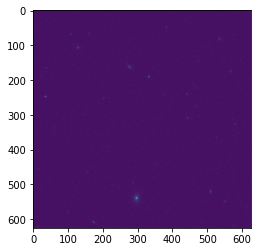

In [34]:
image = sim_field(cat, 0.1, 0.17, 0.003, 2.94)
plt.imshow(image)
fits.writeto('../data/Euclid_VIS_Wide-Survey.fits', image, overwrite=True)


In [ ]:
image = sim_field(cat, 0.1, 0.17, 0.003, 26.94)
plt.imshow(image)
fits.writeto('../data/Euclid_VIS_Wide-Survey.fits', image, overwrite=True)


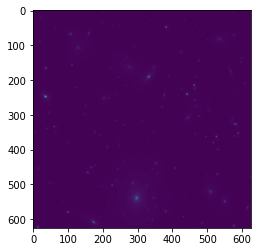

In [33]:
image = sim_field(cat, 0.01, 0.02, 0.0012, 27.85)
plt.imshow(image)
fits.writeto('../data/JWST_NIRCAM_Jades.fits', image, overwrite=True)
